In [1]:
import numpy as np
import pandas as pd
import pickle
import time
import os
from PIL import Image
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from keras_tuner.tuners import RandomSearch
from tensorflow import keras
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense,Conv2D,Activation,Flatten,MaxPooling2D

## EDA

* Identifying Class Imbalance

In [2]:
images = []
list_class = ['glass','no-glass']
select_random = []

for i in range(2):
    
    class_path = os.path.join(os.getcwd(),'train',list_class[i])
    
    images.append([ fn for fn in os.listdir(class_path)]) 

    select_random.append( np.random.choice(images[i], 3, replace = False))

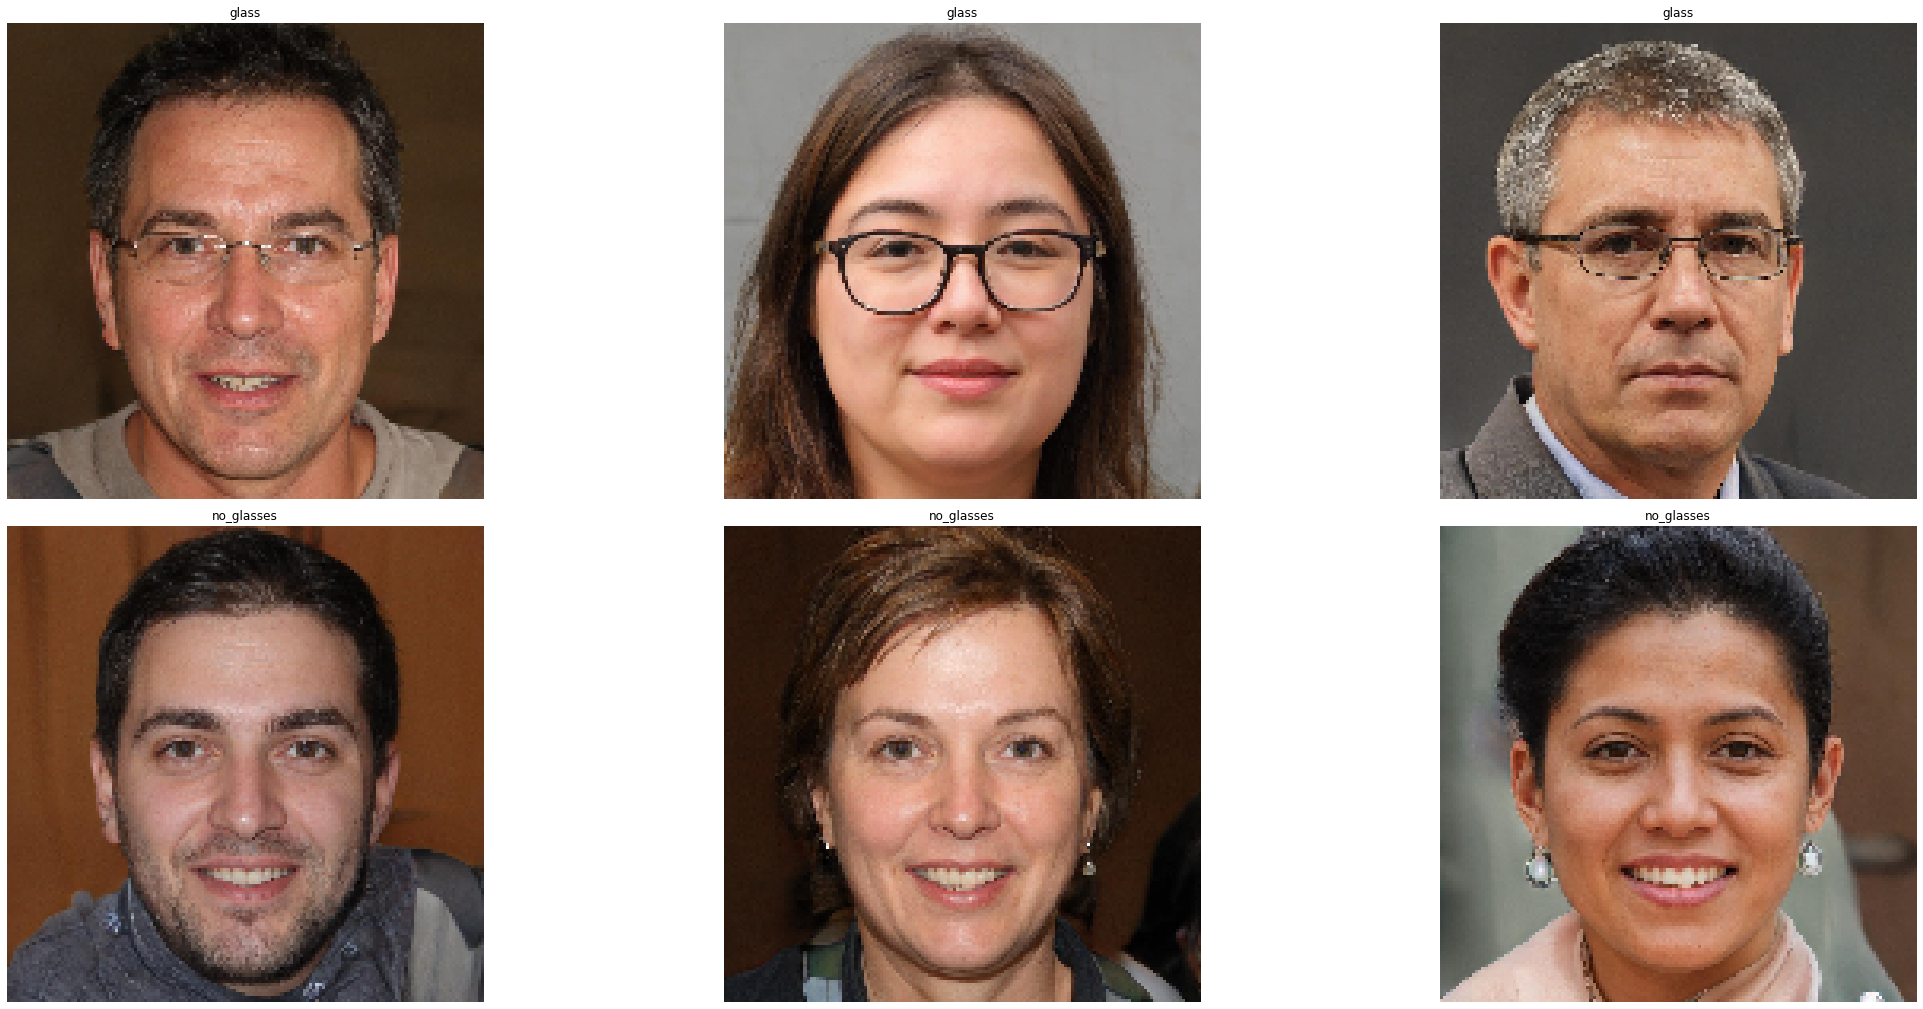

In [3]:
fig = plt.figure(figsize = (30,70))

num = 1

list_label = ['glass','no_glasses']

for i in range(2):
    for j in range(3):
        
        label = list_label[i]
        
        class_path = os.path.join(os.getcwd(),'train',list_class[i])
        
        ax = fig.add_subplot(10, 3, num)
            
        fn = image.load_img(os.path.join(class_path,select_random[i][j]), target_size = (150,150))
        
        plt.imshow(fn)
        plt.title(label)
        plt.axis('off')
        
        num+=1

        
plt.tight_layout()

From what i see :

* Generally image has the face in center , but face maybe not facing to the person that taking the photo
* Some glasses have frame that not quite easy to see like 'face-341' in glasses folder . Some glass have different color(that is not clear like 'face-3') like 'face-2','face-17'

In [4]:
number_classes = {}

for i in range(2):
    class_name = list_class[i]
    
    path_name = os.path.join( os.getcwd() ,"train", class_name )
    
    number_classes[class_name] = len(os.listdir(path_name))

Text(0, 0.5, 'number of image')

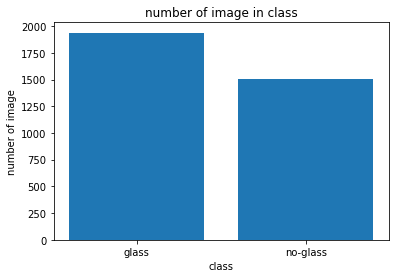

In [5]:
plt.bar(number_classes.keys() , number_classes.values()  )

plt.title('number of image in class')
plt.xlabel('class')
plt.ylabel('number of image')

In [6]:
directories = {}

for i in range(2):
    
    class_name = list_class[i]
    
    path_name = os.path.join( os.getcwd() ,"train" , class_name )
    
    directories[class_name] = path_name

def get_dims(file):
    
    """ Returns dimensions for an RBG image """
    
    im = Image.open(file)
    
    arr = np.array(im)
    
    h,w,d = arr.shape
    
    return h,w

def generate_df_dims(class_path):
    df_dum = []
    
    filelist = [os.path.join(class_path,f) for f in os.listdir(class_path)]
        
    for pic_path in filelist:
        
        h,w = get_dims(pic_path)
        
        df_dum.append((h,w))
        
    return pd.DataFrame(df_dum,columns=['h','w'])
    

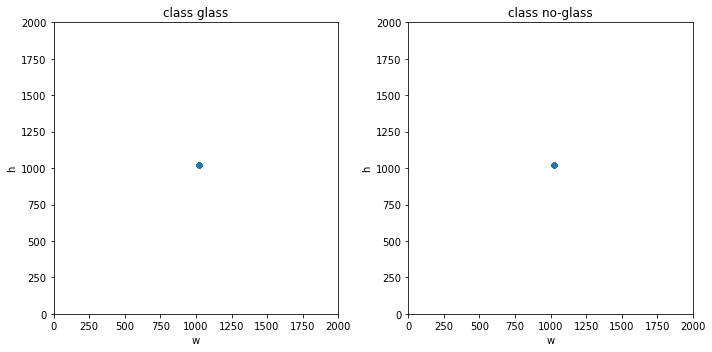

In [18]:
fig, axs = plt.subplots(1, 2,figsize=(10, 5))

num = 0

for j in range(2):
        
    name = list_class[j]

    df_dum = generate_df_dims(directories[name])

    df_dum.plot.scatter(x='w', y='h',ax = axs[j]);

    axs[j].set_title('class'+' '+list_class[j])
    axs[j].set_ylim(0,2000)
    axs[j].set_xlim(0,2000)

    num+=1

# plt.title('Image size in each class')
plt.tight_layout()
        


In [9]:
# making n X m matrix
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in list_of_filename:
        fp = os.path.join(path,fn)
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

train_dir = os.path.join(os.getcwd(),'train')

glass_imgs = [fn for fn in os.listdir(f'{train_dir}/glass') ]
no_glass_imgs = [fn for fn in os.listdir(f'{train_dir}/no-glass') ]

# run it on our folders

glass_images = img2np(os.path.join(train_dir,'glass'),glass_imgs)
no_glass_images = img2np(os.path.join(train_dir,'no-glass'),no_glass_imgs)

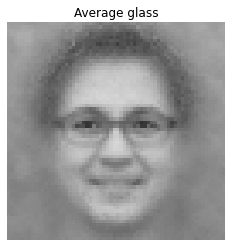

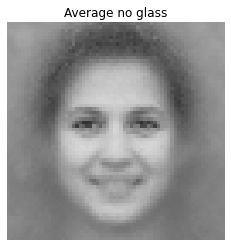

In [12]:
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

glass_mean = find_mean_img(glass_images, 'glass')
no_glass_mean = find_mean_img(no_glass_images, 'no glass')

Area around eye shape a glasses for average glass

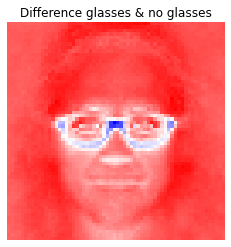

In [14]:
contrast_mean = glass_mean - no_glass_mean
plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'Difference glasses & no glasses')
plt.axis('off')
plt.show()

Difference between glass and no glass seen on area around eye , as expected , that shape glasses

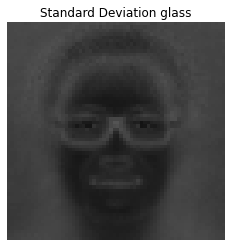

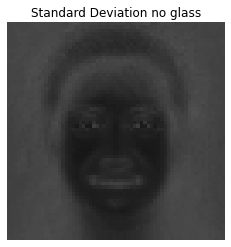

In [16]:
def find_std_img(full_mat, title, size = (64, 64)):
    # calculate the average
    std_img = np.std(full_mat, axis = 0)
    # reshape it back to a matrix
    std_img = std_img.reshape(size)
    plt.imshow(std_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Standard Deviation {title}')
    plt.axis('off')
    plt.show()
    return std_img

glass_std = find_std_img(glass_images, 'glass')
no_glass_std = find_std_img(no_glass_images, 'no glass')

Picture with glasses show much variability(shown by lighter color) around eye

In [13]:
def make_model_v1(size , learning_rate = 0.01 ):
    """Beginning of Model Architecture"""
    
    model = keras.models.Sequential()

    # specify convolutional layer 

    # convolutional layer 1
    model.add(Conv2D(filters = 32,kernel_size = (3,3),input_shape = (size[0],size[1],3) ,activation = 'relu' ))
#     model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # convolutional layer 2
    model.add(Conv2D(filters = 32,kernel_size = (3,3) , activation ='relu'))
#     model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # make a feature vector
    model.add(Flatten())

    # dense layer

    # hidden layer 1
    model.add(Dense(10 , activation = 'relu'))
#     model.add(Activation('relu'))

    # output layer
    model.add(Dense(1, activation = 'sigmoid') )
#     model.add(Activation('sigmoid'))

    """End of Model architecture"""

    """
    optimizer
    """

    # SGD 

    optimizer = tf.keras.optimizers.SGD(learning_rate  = learning_rate , momentum = 0.8)

    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])

    
    return model


In [14]:
# Make generator for training and validation data

size = (299,299)

train_gen = ImageDataGenerator(
    rescale=1./255
)

train_ds = train_gen.flow_from_directory(
    './train/',
    target_size = size,
    batch_size = 20,
    class_mode = 'binary',
    shuffle = True
)

val_gen = ImageDataGenerator(
    rescale=1./255
)

val_ds = val_gen.flow_from_directory(
    './val',
    target_size = size,
    batch_size = 20,
    class_mode = 'binary',
    shuffle = False
)

Found 3443 images belonging to 2 classes.
Found 737 images belonging to 2 classes.


In [17]:
scores = {}

for lr in [0.001 , 0.001 , 0.01 , 0.1]:
    
    # define checkpoint for every learning rate
    filename = 'model_v1_{epoch:02d}_{val_accuracy:.3f}.h5'
    filepath = os.path.join(os.getcwd(),'checkpoint','model_v1',f'lr={lr}',filename)
    
    checkpoint =keras.callbacks.ModelCheckpoint(
    filepath ,
    save_best_only=False,
    monitor = 'val_accuracy',
    mode = 'max' ,
    save_freq = 'EPOCH'
)
    
    model=make_model_v1(size=size,learning_rate = lr)
    history = model.fit(train_ds,epochs=10,validation_data=val_ds,callbacks = [checkpoint])
    scores[lr] = history.history
    

Epoch 1/10
173/173 [==============================] - 315s 2s/step - loss: 0.6625 - accuracy: 0.5571 - val_loss: 0.6165 - val_accuracy: 0.6255
Epoch 2/10
173/173 [==============================] - 315s 2s/step - loss: 0.5649 - accuracy: 0.7363 - val_loss: 0.4988 - val_accuracy: 0.7843
Epoch 3/10
173/173 [==============================] - 316s 2s/step - loss: 0.4359 - accuracy: 0.8344 - val_loss: 0.3385 - val_accuracy: 0.8399
Epoch 4/10
173/173 [==============================] - 316s 2s/step - loss: 0.2451 - accuracy: 0.9094 - val_loss: 0.1480 - val_accuracy: 0.9688
Epoch 5/10
173/173 [==============================] - 263s 2s/step - loss: 0.1280 - accuracy: 0.9625 - val_loss: 0.1342 - val_accuracy: 0.9512
Epoch 6/10
173/173 [==============================] - 220s 1s/step - loss: 0.0902 - accuracy: 0.9736 - val_loss: 0.0821 - val_accuracy: 0.9810
Epoch 7/10
173/173 [==============================] - 260s 2s/step - loss: 0.0644 - accuracy: 0.9814 - val_loss: 0.0565 - val_accuracy: 0.9851

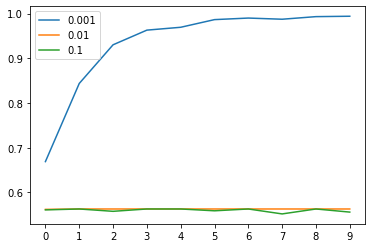

In [18]:
for lr,hist in scores.items():
    plt.plot(hist['accuracy'],label = lr)

plt.xticks(np.arange(10))
plt.legend()